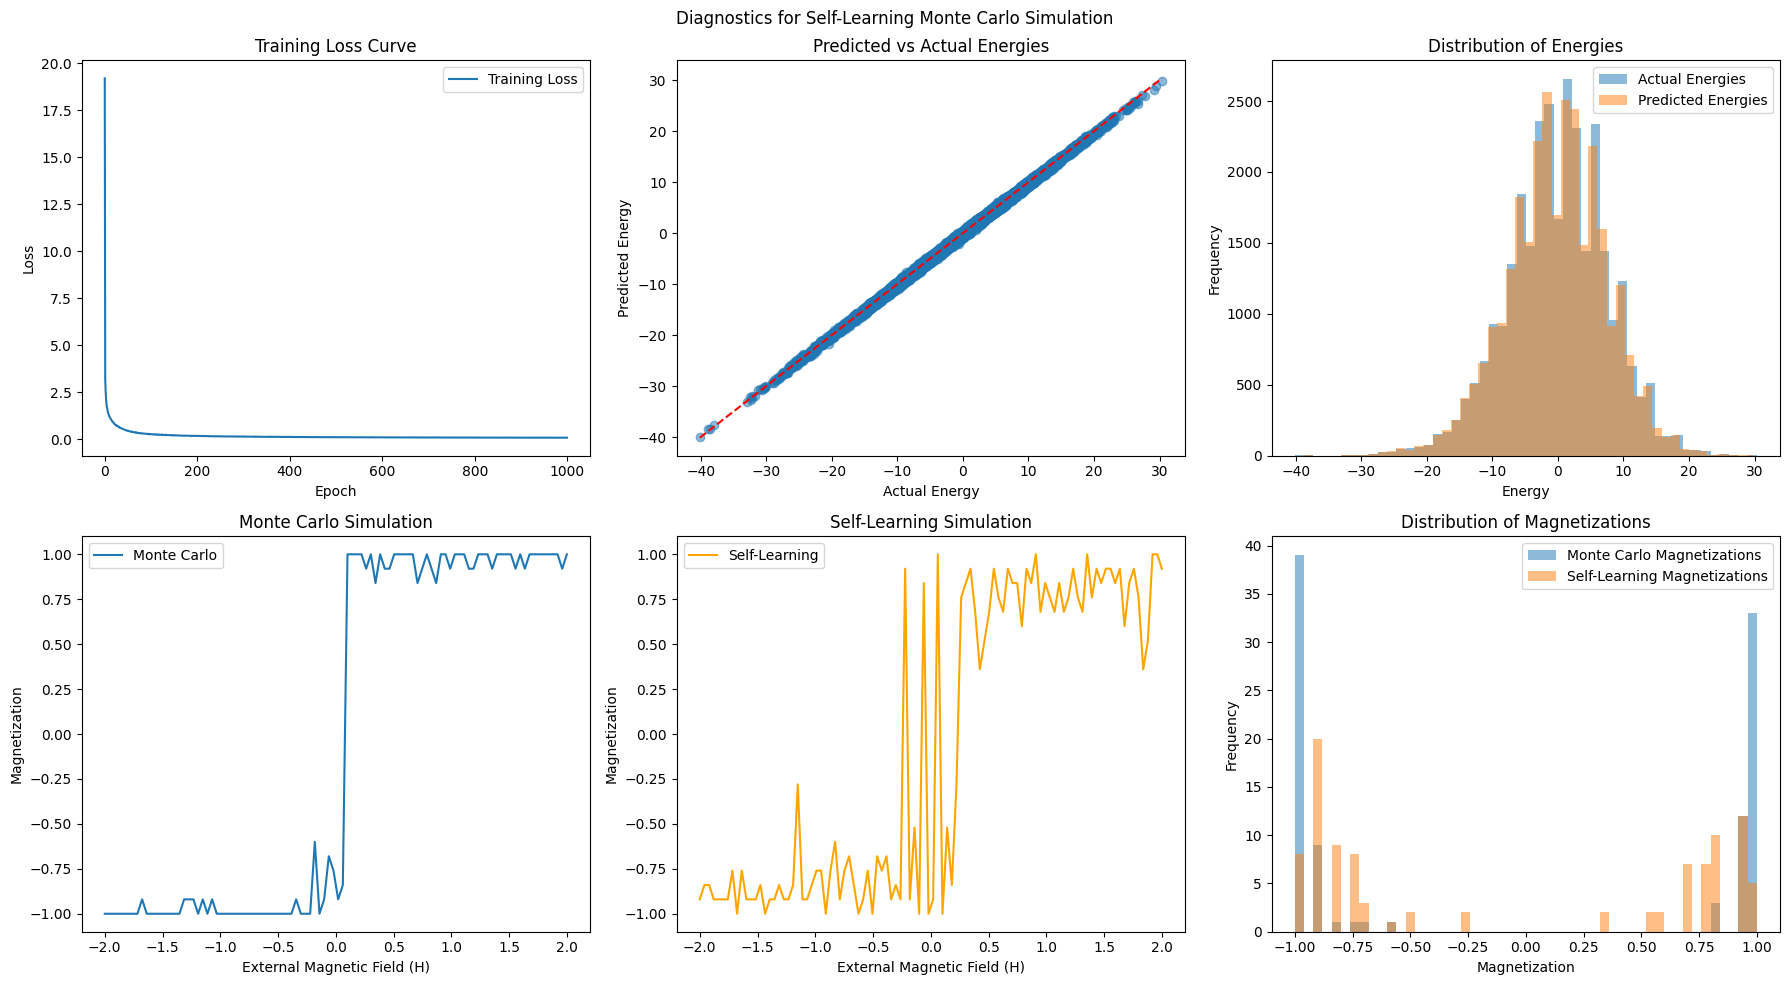

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Parameters
L = 5  # Size of the lattice (LxL)
T = 2.0  # Temperature
num_samples = 30000  # Number of samples for training
steps = 10000  # Number of Monte Carlo steps per H value
H_values = np.linspace(-2, 2, 100)  # Range of external magnetic field values
dim = 64

# Initialize the 2D Ising model
def initialize_lattice(L):
    return np.random.choice([-1, 1], size=(L, L))

# Calculate the energy of a spin configuration
def calculate_energy(lattice, H):
    energy = -np.sum(lattice * (np.roll(lattice, 1, axis=0) + np.roll(lattice, -1, axis=0) +
                                np.roll(lattice, 1, axis=1) + np.roll(lattice, -1, axis=1)))
    energy -= H * np.sum(lattice)
    return energy / 2  # Each pair counted twice

# Generate dataset of configurations and energies
def generate_dataset(L, num_samples):
    data = []
    for _ in range(num_samples):
        lattice = initialize_lattice(L)
        H = np.random.uniform(-2, 2)
        energy = calculate_energy(lattice, H)
        data.append((lattice.flatten(), energy, H))
    return data

# Neural Network Model
class EnergyPredictor(nn.Module):
    def __init__(self, input_size):
        super(EnergyPredictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

# Training function for the neural network
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(train_loader))
    return model, loss_history

# Self-learning algorithm using the neural network
class SelfLearningIsing:
    def __init__(self, L, T, model):
        self.L = L
        self.T = T
        self.model = model
        self.spins = initialize_lattice(L)

    def self_learning_simulation(self, H_values, steps):
        magnetizations = []
        for H in H_values:
            for _ in range(steps):
                i, j = np.random.randint(self.L, size=2)
                new_spins = self.spins.copy()
                new_spins[i, j] *= -1

                current_input = torch.tensor(np.append(self.spins.flatten(), H), dtype=torch.float32).unsqueeze(0)
                new_input = torch.tensor(np.append(new_spins.flatten(), H), dtype=torch.float32).unsqueeze(0)

                current_energy = self.model(current_input).item()
                new_energy = self.model(new_input).item()

                delta_E = new_energy - current_energy
                if delta_E < 0 or np.random.rand() < np.exp(-delta_E / self.T):
                    self.spins[i, j] = new_spins[i, j]

            magnetization = np.sum(self.spins) / (self.L * self.L)
            magnetizations.append(magnetization)
        return magnetizations

# Monte Carlo simulation for comparison
def monte_carlo_simulation(L, T, H_values, steps):
    lattice = initialize_lattice(L)
    magnetizations = []

    for H in H_values:
        for _ in range(steps):
            i, j = np.random.randint(L, size=2)
            delta_E = 2 * lattice[i, j] * (lattice[(i-1) % L, j] + lattice[(i+1) % L, j] +
                                           lattice[i, (j-1) % L] + lattice[i, (j+1) % L]) + 2 * H * lattice[i, j]
            if delta_E < 0 or np.random.rand() < np.exp(-delta_E / T):
                lattice[i, j] *= -1
        magnetization = np.sum(lattice) / (L * L)
        magnetizations.append(magnetization)

    return magnetizations

# Generate dataset
data = generate_dataset(L, num_samples)
spins, energies, fields = zip(*data)
spins = np.array(spins)
energies = np.array(energies)
fields = np.array(fields)

# Prepare data loaders
train_data = TensorDataset(torch.tensor(np.column_stack((spins, fields)), dtype=torch.float32),
                           torch.tensor(energies, dtype=torch.float32).unsqueeze(1))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Initialize and train the neural network
model = EnergyPredictor(input_size=L*L + 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model, loss_history = train_model(model, train_loader, criterion, optimizer, epochs=1000)

# Perform self-learning simulation
self_learning_model = SelfLearningIsing(L, T, model)
sl_magnetizations = self_learning_model.self_learning_simulation(H_values, steps)

# Perform Monte Carlo simulation
mc_magnetizations = monte_carlo_simulation(L, T, H_values, steps)

# Plotting results
plt.figure(figsize=(18, 10))

# Loss curve
plt.subplot(2, 3, 1)
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Predicted vs actual energies
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(np.column_stack((spins, fields)), dtype=torch.float32)).squeeze().numpy()

plt.subplot(2, 3, 2)
plt.scatter(energies, predictions, alpha=0.5)
plt.plot([energies.min(), energies.max()], [energies.min(), energies.max()], 'r--')
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.title('Predicted vs Actual Energies')

# Distribution of energies
plt.subplot(2, 3, 3)
plt.hist(energies, bins=50, alpha=0.5, label='Actual Energies')
plt.hist(predictions, bins=50, alpha=0.5, label='Predicted Energies')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of Energies')
plt.legend()

# Magnetization results
plt.subplot(2, 3, 4)
plt.plot(H_values, mc_magnetizations, label='Monte Carlo')
plt.xlabel('External Magnetic Field (H)')
plt.ylabel('Magnetization')
plt.title('Monte Carlo Simulation')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(H_values, sl_magnetizations, label='Self-Learning', color='orange')
plt.xlabel('External Magnetic Field (H)')
plt.ylabel('Magnetization')
plt.title('Self-Learning Simulation')
plt.legend()

# Distribution of magnetizations
plt.subplot(2, 3, 6)
plt.hist(mc_magnetizations, bins=50, alpha=0.5, label='Monte Carlo Magnetizations')
plt.hist(sl_magnetizations, bins=50, alpha=0.5, label='Self-Learning Magnetizations')
plt.xlabel('Magnetization')
plt.ylabel('Frequency')
plt.title('Distribution of Magnetizations')
plt.legend()

plt.suptitle('Diagnostics for Self-Learning Monte Carlo Simulation')
plt.tight_layout()
plt.show()
